Load the data (images shape: 7000 x 28 x 28, labels shape: 7000)


In [18]:
!pip install tensorflow
!pip install keras

In [19]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model, Input
from keras import Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import numpy as np
import pickle as pk
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras import models, layers



In [20]:
with open('input_data.pkl', 'rb') as f:
    dd = pk.load(f)

data = dd['data']
labels = dd['labels']

X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    test_size=0.2,
    random_state=42
)

print(X_train.shape, y_train.shape)


(5600, 28, 28) (5600,)


data is (7000, 28, 28), label is a 1D vector with 7000 values

CHANGE: Instead of no preprocessing, a minMaxScaler would be better on the pixels (between 0 and 1)
but could simply divide by 255 every value, same effect!

np.max(X_train[0]):1.0


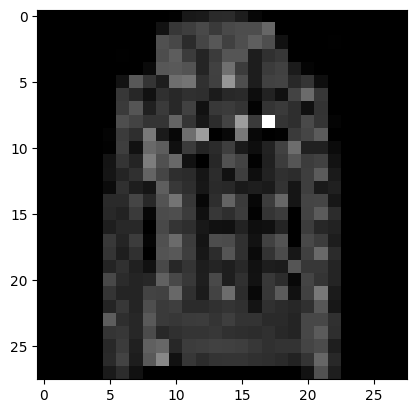

In [21]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

plt.imshow(X_train[0].squeeze(), cmap='gray')
print(f"np.max(X_train[0]):{np.max(X_train[0])}")

In [22]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print(f"X_train.shape:{X_train.shape}")
print(f"X_test.shape:{X_test.shape}")
print(f"np.max(X_train):{np.max(X_train)}, np.min(X_train):{np.min(X_train)}")

X_train.shape:(5600, 28, 28, 1)
X_test.shape:(1400, 28, 28, 1)
np.max(X_train):1.0, np.min(X_train):0.0


In [23]:
n_classes = len(np.unique(y_train))
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(f"n_classes:{n_classes}, input_shape:{input_shape}")

n_classes:10, input_shape:(28, 28, 1)


CHANGE: instead of searching from 4 to 10 (kernel size), i chose to tighten the bound to 5, 7, 9, which would save me a lot of time. not that big of a change, just faster. + ANOTHER CHANGE: instead of using grid search, i decided to use a separate CNN to find the optimal kernel size, so that on each iteration i wouldnt have to wait for the kernel size to be decided. this cnn says the best results are obtained with 5x5, and so from this point i used the 5x5 kernel.

In [24]:
kernel_sizes = [5, 7, 9]  # Test these kernel sizes
best_accuracy = 0
best_model = None
best_kernel = None

for k_size in kernel_sizes:
    print(f"Testing kernel size: {k_size}x{k_size}")

    model = Sequential([
        Conv2D(64, kernel_size=(k_size, k_size),
               input_shape=input_shape,
               padding='same',
               activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        layers.Dense(128, activation="relu"),  # expand
        layers.Dense(256, activation="relu"),  # expand more
        layers.Dense(128, activation="relu"),  # contract
        layers.Dense(64, activation="relu"),   # contract more
        layers.Dense(10, activation="softmax") # output layer
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                       batch_size=64,
                       epochs=10,
                       verbose=1,
                       validation_data=(X_test, y_test))

    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_kernel = k_size
        best_model = model
        print(f"New best kernel: {k_size}x{k_size} with accuracy: {val_acc:.4f}")


print(f"\nSaved best model with kernel size {best_kernel}x{best_kernel} ")

Testing kernel size: 5x5
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.5294 - loss: 1.2785 - val_accuracy: 0.7850 - val_loss: 0.6121
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8125 - loss: 0.5254 - val_accuracy: 0.8257 - val_loss: 0.4883
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8480 - loss: 0.4192 - val_accuracy: 0.8386 - val_loss: 0.4621
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8732 - loss: 0.3530 - val_accuracy: 0.8364 - val_loss: 0.4438
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8882 - loss: 0.3042 - val_accuracy: 0.8414 - val_loss: 0.4608
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9078 - loss: 0.2544 - val_accuracy: 0.8614 - val_loss: 0.3964
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9269 - loss: 0.2110 - val_accuracy: 0.8593 - val_loss: 0.4379
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9243 - loss: 0.2225 - val_accuracy: 0.8471 - val_loss: 0.4499

5x5 turned out to be the best! so will use 5X5 kernel (1 convolution).

In [25]:
conv_model = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
])
best_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
best_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9312 - loss: 0.1863
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9472 - loss: 0.1488
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9627 - loss: 0.1018
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9666 - loss: 0.0906
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9651 - loss: 0.0965


In [26]:
mlp_model = Sequential([
    layers.Input(shape=(conv_model.output_shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [27]:
inputs = Input(shape=(28, 28, 1))
x = conv_model(inputs)
outputs = mlp_model(x)
model = Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5252 - loss: 1.3256 - val_accuracy: 0.7529 - val_loss: 0.6480
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7783 - loss: 0.5853 - val_accuracy: 0.8121 - val_loss: 0.5003
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8285 - loss: 0.4707 - val_accuracy: 0.8186 - val_loss: 0.5012
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8420 - loss: 0.4359 - val_accuracy: 0.8214 - val_loss: 0.4497
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8691 - loss: 0.3644 - val_accuracy: 0.8286 - val_loss: 0.5034
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8816 - loss: 0.3458 - val_accuracy: 0.8414 - val_loss: 0.4332
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8907 - loss: 0.3013 - val_accuracy: 0.8279 - val_loss: 0.5181
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8869 - loss: 0.3072 - val_accuracy: 0.8464 - val_loss

CHANGE: an error I have made in my exam, is to incorrectly answer the loss and metric of the VAE (on metric i wrote accuracy, on loss I wrote the standard formula 1/n sum (d-z)). And so for the VAE to correctly work I shall use KL Divergence as the loss function, and Mean Squared Error as the metric.

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

latent_dim = 2
flat_input_dim = 4608  # output shape from convolution

encoder_inputs = Input(shape=(flat_input_dim,))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(256, activation='relu')(x)
decoder_outputs = layers.Dense(flat_input_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# VAE
outputs = decoder(z)
vae = Model(encoder_inputs, outputs, name='vae')

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.abs(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.summary()

conv_out = conv_model.predict(X_train)
conv_out = conv_out.reshape(conv_out.shape[0], -1)
print(f"conv_out.shape:{conv_out.shape}")
vae.fit(conv_out, conv_out, epochs=10, batch_size=32)


Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 2), (None, 2), │     1,213,316 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 4608)           │     1,217,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,980 (9.27 MB)

 Trainable params: 2,430,980 (9.27 MB)

 Non-trainable params: 0 (0.00 B)

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
conv_out.shape:(5600, 4608)
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 0.0017 - loss: 0.0986 - reconstruction_loss: 0.0969
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 6.4180e-05 - loss: 0.0417 - reconstruction_loss: 0.0417
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 3.8352e-05 - loss: 0.0410 - reconstruction_loss: 0.0410
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 2.7596e-05 - loss: 0.0403 - reconstruction_loss: 0.0403
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 2.1842e-05 - loss: 0.0399 - reconstruction_loss: 0.0399
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 1.4182e-05 - loss: 0.0398 - reconstruction_loss: 0.0398
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 1.1705e-05 - loss: 0.0398 - reconstruction_loss: 0.0398
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 1.1245e-05 - loss: 0.0398 - reconstruct

The reconstruction loss is around 0.0339, which means the model is doing a good job recreating the input images.

The KL loss is very small, so the latent space is close to a normal distribution, but it doesn't affect the total loss much.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


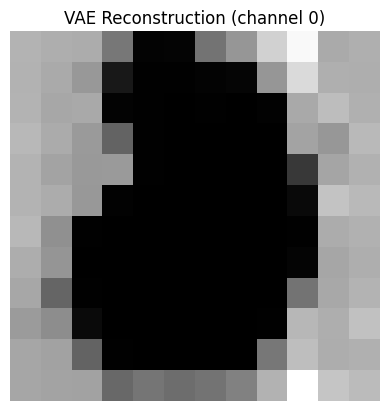

In [29]:
x_sample = X_test[0:1]
flat_input = conv_model.predict(x_sample).reshape(1, -1)
reconstructed = vae.decoder(vae.encoder(flat_input)[2]).numpy().reshape(12, 12, 32)

plt.imshow(reconstructed[:, :, 0], cmap='gray')  # Show just the first channel
plt.axis('off')
plt.title("VAE Reconstruction (channel 0)")
plt.show()
